# Simultaneous sparse inference and data trimming: Lorenz example

This notebook performs the SR3-trimming algorithm on an example dataset of the Lorenz system with corrupted samples.

In [1]:
import sys
import numpy as np
from scipy.integrate import odeint

import pysindy as ps
sys.path.insert(0, '..')
from utils import *
from sr3_enhanced import SR3Enhanced

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Generate corrupted training data

In [2]:
corrupt_fraction = 0.1
corruption_strength = 50
trimmed_fraction = 0.4

In [3]:
np.random.seed(1)

# time grid set up
ts = 0.0
te = 10.0
dt = .005
t = np.arange(ts,te,dt)

# ode set up
lorenz = lambda z,t : [10*(z[1] - z[0]), z[0]*(28 - z[2]) - z[1], z[0]*z[1] - 8/3*z[2]]

n_trajectories = 5
x0s = 2*np.array([36,48,41])*(np.random.rand(n_trajectories, 3)-.5) + np.array([0,0,25])
x = []
for i in range(n_trajectories):
    x.append(odeint(lorenz, x0s[i], t))
    
true_coefficients = np.zeros((20,3))
true_coefficients[1,0] = -10
true_coefficients[2,0] = 10
true_coefficients[1,1] = 28
true_coefficients[2,1] = -1
true_coefficients[6,1] = -1
true_coefficients[3,2] = -8/3
true_coefficients[5,2] = 1

In [4]:
# add noise and corruption
x_corrupted = add_noise(x, std=1e-3)
corrupted_idxs = corrupt_data(x_corrupted, corrupt_fraction=corrupt_fraction, corruption_strength=corruption_strength)
n_corrupted_idxs = sum([corrupted_idxs[i].size for i in range(n_trajectories)])

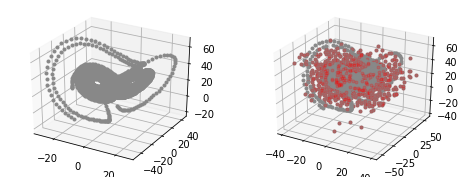

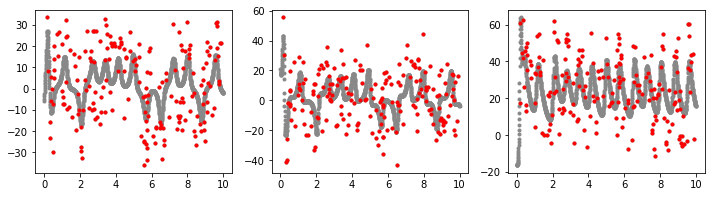

In [5]:
# plot uncorrupted data - 3D
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(121, projection='3d')
for i in range(n_trajectories):
    ax.plot(x[i][:,0],x[i][:,1],x[i][:,2],'.',color='#888888')

# plot corrupted data - 3D
ax = fig.add_subplot(122, projection='3d')
for i in range(n_trajectories):
    ax.plot(x_corrupted[i][:,0],x_corrupted[i][:,1],x_corrupted[i][:,2],'.',color='#888888')
    ax.plot(x_corrupted[i][:,0][corrupted_idxs[i]], x_corrupted[i][:,1][corrupted_idxs[i]],
            x_corrupted[i][:,2][corrupted_idxs[i]], '.r', alpha=0.2)

# plot corrupted data - time series
plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(t, x_corrupted[0][:,i], '.', color='#888888')
    plt.plot(t[corrupted_idxs[0]], x_corrupted[0][:,i][corrupted_idxs[0]], '.r')

## Perform SR3 with trimming

In [6]:
sr3_optimizer = SR3Enhanced(threshold=0.1, nu=1, trimming_fraction=1-trimmed_fraction,
                               max_iter=2000, tol=1e-2)
library = ps.PolynomialLibrary(degree=3)

model = ps.SINDy(optimizer=sr3_optimizer, feature_library=library)
model.fit(x_corrupted, t=dt, multiple_trajectories=True, unbias=False)
model.print()

x0' = -10.025 x0 + 10.016 x1
x1' = 28.072 x0 + -1.024 x1 + -1.005 x0 x2
x2' = -2.665 x2 + 1.008 x0 x1


## Analyze and plot results

In [7]:
# print results
mismatched_coefficients = np.sum((true_coefficients==0) != (model.coefficients().T==0))
print('corrupted data mismatched coefficients: %d' % mismatched_coefficients)
if mismatched_coefficients > 0:
    print(model.coefficients().T)

trimmed_idxs = []
trimming_array_list = []
start_idx=0
for i in range(n_trajectories):
    end_idx = start_idx+x_corrupted[i].shape[0]
    tmp = model.model.steps[1][1].optimizer.trimming_array[start_idx:end_idx]
    trimming_array_list.append(tmp)
    trimmed_idxs.append(np.where(tmp == 0)[0])
    start_idx = end_idx

missed_corrupt_samples = 0
total_trimmed_samples = 0
for i in range(n_trajectories):
    missed_corrupt_samples += np.sum(trimming_array_list[i][corrupted_idxs[i]])
    total_trimmed_samples += trimmed_idxs[i].size                             
print('missed %d out of %d corrupt samples' % (missed_corrupt_samples, n_corrupted_idxs))
print('trimmed %d samples out of %d total samples' % (total_trimmed_samples, sum([xi.shape[0] for xi in x_corrupted])))

corrupted data mismatched coefficients: 0
missed 0 out of 1000 corrupt samples
trimmed 3958 samples out of 10000 total samples


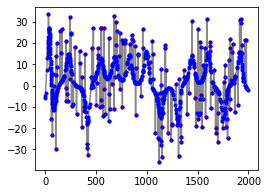

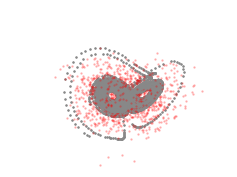

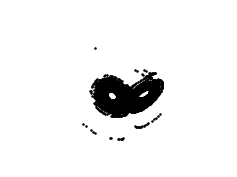

In [8]:
# plot time series with corrupted points in red and trimmed points in blue
plt.figure(figsize=(4,3))
plt.plot(x_corrupted[0][:,0], color='#888888')
plt.plot(corrupted_idxs[0], x_corrupted[0][:,0][corrupted_idxs[0]], '.r')
plt.plot(trimmed_idxs[0], x_corrupted[0][:,0][trimmed_idxs[0]], '.b')

# plot true and corrupted data - 3D
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
for ic_idx in range(n_trajectories):
    uncorrupted_idxs = np.setdiff1d(np.arange(x_corrupted[ic_idx][:,0].size), corrupted_idxs[ic_idx])
    # ax.plot(x_corrupted[0,:,0],x_corrupted[0,:,1],x_corrupted[0,:,2],'.', color='#888888')
    ax.plot(x_corrupted[ic_idx][:,0][uncorrupted_idxs],x_corrupted[ic_idx][:,1][uncorrupted_idxs],
            x_corrupted[ic_idx][:,2][uncorrupted_idxs], '.', color='#888888', markersize=3, rasterized=True)
    ax.plot(x_corrupted[ic_idx][:,0][corrupted_idxs[ic_idx]], x_corrupted[ic_idx][:,1][corrupted_idxs[ic_idx]],
            x_corrupted[ic_idx][:,2][corrupted_idxs[ic_idx]], '.r', alpha=0.2, markersize=3, rasterized=True)   
ax.axis('off')
ax.set_xlim3d([-40,40])
ax.set_ylim3d([-60,40])
ax.set_zlim3d([0,80])
# fig.savefig('lorenz_corrupted.pdf', dpi=600)

# plot data left after trimming
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
for ic_idx in range(n_trajectories):
    untrimmed_idxs = np.setdiff1d(np.arange(x_corrupted[ic_idx][:,0].size), trimmed_idxs[ic_idx])
    ax.plot(x_corrupted[ic_idx][:,0][untrimmed_idxs],x_corrupted[ic_idx][:,1][untrimmed_idxs],
            x_corrupted[ic_idx][:,2][untrimmed_idxs], '.k', markersize=3, rasterized=True)
ax.axis('off')
ax.set_xlim3d([-40,40])
ax.set_ylim3d([-60,40])
ax.set_zlim3d([0,80])
# fig.savefig('lorenz_trimmed.pdf', dpi=600)